# vdl Depth and Class Constrained Diffusion
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

## Dataset Preparation

- 894 classes -> 18 classes

In [72]:
from data.nyuv2 import NYUDepthV2
from torchvision import transforms
from torch.utils.data import DataLoader

mean = [0.5105, 0.4662, 0.4438]
std = [0.2273, 0.2275, 0.2409]

image_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

crop_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
])

dataset = NYUDepthV2(root='data', 
                     download=True, 
                     preload=False, 
                     image_transform=image_t, 
                     seg_transform=crop_t, 
                     depth_transform=crop_t, 
                     filtered_classes=[5, 11, 21, 26, 2, 3, 7, 64, 144, 19, 119, 157, 28, 55, 15, 59, 4, 83])

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Dataset already exists, skipping download.


In [73]:
from data import split_dataset

In [74]:
import torch
import matplotlib.pyplot as plt

def unnormalize(img, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)  # Reshape to [C, 1, 1]
    std = torch.tensor(std).view(-1, 1, 1)    # Reshape to [C, 1, 1]
    img = std * img + mean
    img = torch.clip(img, 0, 1)
    return img

dataset[0][4].shape

(18,)

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Modules

In [76]:
from core import UNet_Baseline
from core import UNet_Attn

# Instantiate the model
baseline = UNet_Baseline(num_classes=18, device=device).to(device)
attn = UNet_Attn(num_classes=18, device=device).to(device)

# Dummy inputs
x = torch.randn(1, 3, 64, 64).to(device)
t = torch.randint(0, 1000, (x.shape[0],)).to(device)
class_vector = torch.ones((x.shape[0], 18)).to(device)
depth_vector = torch.zeros((x.shape[0], 18)).to(device)

for net in [baseline, attn]:
    output = net(x, t, class_vector, depth_vector)
    print(f'--- Model: {net.__class__.__name__} ---')
    print(f"Total parameters: {sum(p.numel() for p in net.parameters())}")
    print(f'Input shape: {x.shape}')
    print(f"Output shape: {output.shape}")
    print()

--- Model: UNet_Baseline ---
Total parameters: 1771907
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])

--- Model: UNet_Attn ---
Total parameters: 23539331
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])



## Diffusion

In [77]:
from diffusion import Diffusion

## Trainer

In [78]:
from trainer import Trainer

In [79]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[:24], train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training samples: 16
Validation samples: 4
Testing samples: 4


In [80]:
from core import UNet_Attn
# import copy here
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Attn(num_classes=18, dropout_prob=0.2, device=device).to(device)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

ema_model.load_state_dict(torch.load('models/unet_attn_dropout_0.2_o6mtkrvr_ema.pth', map_location=device))

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_85309/1153786167.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ema_model.load_state_dict(torch.load('models

<All keys matched successfully>

In [81]:
# a 894-dimensional class vector with some 1s and 0s
class_vector = torch.tensor(dataset[0][3]).unsqueeze(0)
depth_vector = torch.tensor(dataset[0][4]).unsqueeze(0)

dataset.resolved_names 

class_vector = torch.tensor([0]*18)
print(dataloader.dataset.resolved_names)

class_vector[0] = 1
class_vector[15] = 1

depth_vector = torch.tensor([0]*18)
depth_vector[0] = 1.3
depth_vector[15] = 3.0

['chair' 'floor' 'wall' 'box' 'bottle' 'cabinet' 'counter' 'picture'
 'lamp' 'table' 'pillow' 'bed' 'door' 'bag' 'paper' 'window' 'ceiling'
 'sofa']


In [82]:
class_vector.shape, depth_vector.shape

(torch.Size([18]), torch.Size([18]))

In [83]:
diffusion = Diffusion(beta_start=0.0001, beta_end=0.002, device=device)

sampled_images = diffusion.sample(ema_model, 1, torch.tensor(train_dataset[1][3]).unsqueeze(0).to(device), torch.tensor(train_dataset[1][4]).unsqueeze(0).to(device))

01:17:27 - INFO: Sampling 1 new images from UNet_Attn...
999it [03:44,  4.45it/s]


In [84]:
sampled_images.shape

torch.Size([1, 3, 64, 64])

In [85]:
#plt.imshow(train_dataset[1][0].permute(1,2,0))
train_dataset[1][3], train_dataset[1][4]

(array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        0.], dtype=float32),
 array([3.899875 , 5.4697165, 3.951857 , 3.3675194, 4.5320315, 3.1576278,
        5.00796  , 9.751564 , 0.       , 4.110116 , 0.       , 0.       ,
        0.       , 0.       , 3.459803 , 4.5213976, 3.1027713, 0.       ],
       dtype=float32))

01:30:06 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.83949333..0.6783387].


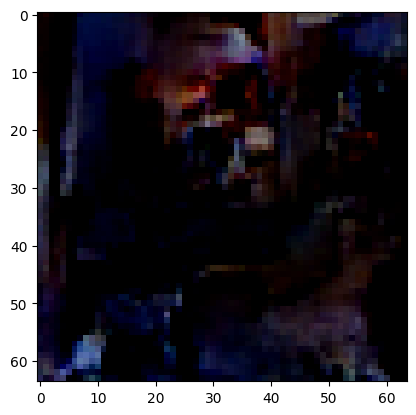

In [88]:
from data import unnormalize

import torch

def unnormalize_image(image_tensor, mean, std, value_range="[0, 1]"):
    """
    Unnormalize an image tensor with shape (3, 64, 64).

    Args:
        image_tensor (torch.Tensor): The input image tensor of shape (3, 64, 64).
        mean (list): List of 3 elements representing the mean for each channel (R, G, B).
        std (list): List of 3 elements representing the standard deviation for each channel (R, G, B).
        value_range (str): The desired range for output values: "[0, 1]" or "[0, 255]".

    Returns:
        torch.Tensor: The unnormalized image tensor of shape (3, 64, 64) with values in the specified range.
    """
    if image_tensor.shape != (3, 64, 64):
        raise ValueError("Input tensor must have shape (3, 64, 64)")
    if len(mean) != 3 or len(std) != 3:
        raise ValueError("Mean and std must be lists of 3 elements")
    if value_range not in ["[0, 1]", "[0, 255]"]:
        raise ValueError("value_range must be either '[0, 1]' or '[0, 255]'")

    # Perform unnormalization
    unnormalized = image_tensor.clone()
    for channel in range(3):
        unnormalized[channel] = unnormalized[channel] * std[channel] + mean[channel]

    # Clamp values to [0, 1]
    unnormalized = torch.clamp(unnormalized, 0, 1)

    # If value_range is [0, 255], scale values accordingly
    if value_range == "[0, 255]":
        unnormalized = unnormalized * 255

    return unnormalized

import matplotlib.pyplot as plt

def plot_image(image_tensor, mean, std, value_range="[0, 1]"):
    """
    Unnormalize and plot an image tensor using matplotlib.

    Args:
        image_tensor (torch.Tensor): The input image tensor of shape (3, 64, 64).
        mean (list): List of 3 elements representing the mean for each channel (R, G, B).
        std (list): List of 3 elements representing the standard deviation for each channel (R, G, B).
        value_range (str): The desired range for output values: "[0, 1]" or "[0, 255]".
    """
    # Unnormalize the image
    unnormalized_image = unnormalize_image(image_tensor, mean, std, value_range)

    # Convert to NumPy array
    image_np = unnormalized_image.numpy()

    # Transpose to (H, W, C)
    image_np = image_np.transpose(1, 2, 0)

    # If the range is [0, 255], convert to uint8
    if value_range == "[0, 255]":
        image_np = image_np.astype("uint8")

    # Plot the image
    plt.imshow(image_np)
    plt.axis("off")  # Hide axis for better visualization
    plt.show()

# Example usage:
# Assume `image_tensor` is a tensor with shape (3, 64, 64) and you have mean and std lists
# image_tensor = torch.randn(3, 64, 64)  # Example tensor
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# plot_image(image_tensor, mean, std, value_range="[0, 255]")

plt.imshow(sampled_images[0].cpu().permute(1, 2, 0))
plt.show()

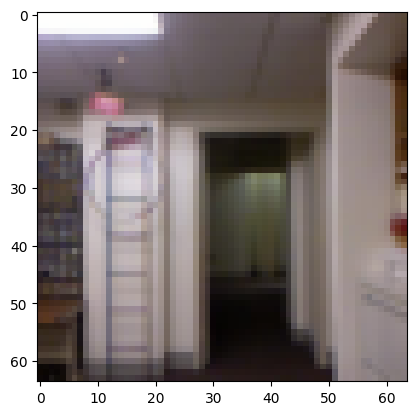

In [91]:
plt.imshow(unnormalize(train_dataset[1][0], mean, std).permute(1, 2, 0))

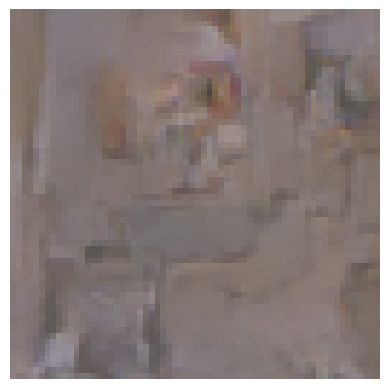

In [87]:
plot_image(sampled_images[0], mean, std, value_range="[0, 1]")